**Tinkoff Lab. Лабораторная работа "Voice anti spoofing"**

В данном задании предлагается решить задачу бинарной классификации пола по записи голоса. В качестве тренировочного и тестового датасета будет использоваться [Common Voice](https://commonvoice.mozilla.org/ru/datasets).

Из-за того, что ресурсы мои невелики, взяла выборку из `train.tsv` размером 2000 и из `test.tsv` размером 400, распределив классы поровну. Для работы с голосом как нельзя лучше подходит библиотека `librosa`, она содержит полезные методы для преобразования аудио.

In [1]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from IPython import display

from scipy import signal
from scipy.io import wavfile

import shutil
from PIL import Image
import numpy as np
import librosa

seed = 42
np.random.seed(seed)

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# для коллаба

# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# для коллаба

# shutil.unpack_archive("drive/MyDrive/data.tar.gz")

Так как работать предстоит с гистограммами, посмотрим как они выглядят.

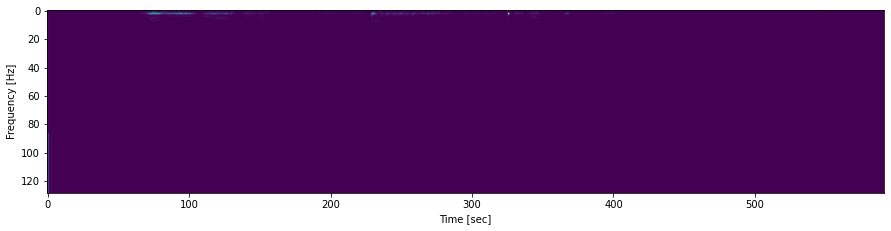

In [5]:
y, sr = librosa.load('data/test/18851610.mp3')
frequencies, times, spectrogram = signal.spectrogram(y, sr)

plt.figure(figsize=(15,10))
plt.pcolormesh(times, frequencies, spectrogram)
plt.imshow(spectrogram)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

Видно, что данные совсем неудобные и не показательные, так что без преобразований не обойтись. Предлагаю использовать мощный `mfcc`.

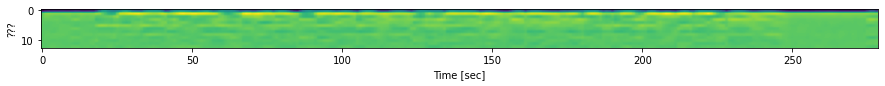

(13, 279)

In [6]:
import librosa

y, sr = librosa.load('data/test/18889669.mp3')
mfcc = librosa.feature.mfcc(y=y, sr=sr, hop_length=512, n_mfcc=13)
plt.figure(figsize=(15,10))
plt.imshow(mfcc)
plt.ylabel('???')
plt.xlabel('Time [sec]')
plt.show()
mfcc.shape

In [ ]:
frequencies.shape, times.shape, spectrogram.shape

((129,), (592,), (129, 592))

Так гораздо презентабельнее. Теперь выберем способ борьбы с различной длиной записей. Пока что можно взять самый глупый способ, в котором выберем универсальную длину и все элементы будем подгонять под неё дополнением или обрезкой. Спойлер, попозже посмотрим на распределение длин, и я покажу, откуда берутся числа, и что этот способ в принципе не такой уж неудачный.

In [7]:
def to_shape(seq, size=1024, ch=129):
  n = seq.shape[1]
  empty = np.array([0.] * size, dtype=np.float32)
  offset = int((n - size) / 2)
  if n < size:
    new_seq = np.array([empty] * ch)
    new_seq[:,-offset:n - offset] = seq
    seq = new_seq
  if n > size:
    seq = seq[:,offset:offset + size]
  return np.array(seq)

Я заранее заготовила файлик с именами элементов моих выборок, все они подмножества изначально предложенных датасетов.

In [8]:
import csv

train_files = []
test_files = []
y_train = []
y_test = []

with open('data/train.csv', newline='') as File:  
    reader = csv.reader(File)
    for row in reader:
      train_files.append(row[0])
      y_train.append(row[1])

with open('data/test.csv', newline='') as File:  
    reader = csv.reader(File)
    for row in reader:
      test_files.append(row[0])
      y_test.append(row[1])


Непосредственно загрузка и одновременно статистика длины записей.

In [9]:
from tqdm import tqdm

lengths = []

X_train = []

for i in tqdm(range(len(train_files))):
  samples, sample_rate = librosa.load('data/train/' + train_files[i])
  lengths.append(samples.shape[0] * 0.00195)
  spectrogram = librosa.feature.mfcc(samples, sample_rate, n_mfcc=64)
  X_train.append(to_shape(np.array(spectrogram, dtype=np.float32), 512, 64))
print('train dataset loaded!')

X_test = []

for i in tqdm(range(len(test_files))):
  samples, sample_rate = librosa.load('data/test/' + test_files[i])
  lengths.append(samples.shape[0] * 0.00195)
  spectrogram = librosa.feature.mfcc(samples, sample_rate, n_mfcc=64)
  X_test.append(to_shape(np.array(spectrogram, dtype=np.float32), 512, 64))
print('test dataset loaded!')


100%|██████████| 2000/2000 [17:13<00:00,  1.94it/s]


train dataset loaded!


100%|██████████| 400/400 [03:38<00:00,  1.83it/s]

test dataset loaded!


(array([ 75., 251., 368., 420., 426., 388., 222., 150.,  75.,  25.]),
 array([ 71.20425 , 109.489185, 147.77412 , 186.059055, 224.34399 ,
        262.628925, 300.91386 , 339.198795, 377.48373 , 415.768665,
        454.0536  ]),
 <a list of 10 Patch objects>)

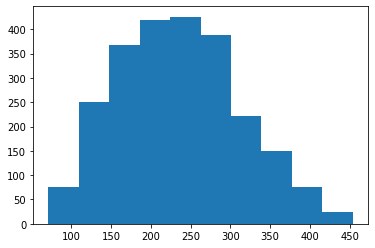

In [10]:
plt.hist(lengths)

Во-первых, длины распределены довольно скученно, то есть нет каких-то выбросов справа. Так что длина 512 покроет все спектрограммы. Некоторую проблему всё же создаст образовавшееся молчание.

Попробуем применить к результату сначала базовые модели. Так как использовать последовательности векторов проблематично, достаточно рассмотреть среднее или медиану по частотам. При этом здесь уже нет необходимости приводить данные к одной длине, поэтому, чтобы не создавать лишних искажений, запишем новый датасет меньшей размерности. Также загрузим датасет таргетов.

*Прошу прощения за названия переменных, в реальной жизни их так называть не принято, но в учебных проектах кажется только так и делают.*

In [11]:
XX_train = []

for i in tqdm(range(len(train_files))):
  samples, sample_rate = librosa.load('data/train/' + train_files[i])
  spectrogram = librosa.feature.mfcc(samples, sample_rate, n_mfcc=64)
  XX_train.append(np.array(spectrogram, dtype=np.float32).mean(axis=1))
print('train dataset loaded!')

XX_test = []

for i in tqdm(range(len(test_files))):
  samples, sample_rate = librosa.load('data/test/' + test_files[i])
  spectrogram = librosa.feature.mfcc(samples, sample_rate, n_mfcc=64)
  XX_test.append(np.array(spectrogram, dtype=np.float32).mean(axis=1))
print('test dataset loaded!')


100%|██████████| 2000/2000 [18:39<00:00,  1.79it/s]


train dataset loaded!


100%|██████████| 400/400 [03:47<00:00,  1.76it/s]

test dataset loaded!


In [12]:
yy_train = []
yy_test = []

with open('data/train.csv', newline='') as File:  
    reader = csv.reader(File)
    for row in reader:
      yy_train.append(row[1])

with open('data/test.csv', newline='') as File:  
    reader = csv.reader(File)
    for row in reader:
      yy_test.append(row[1])

Перемешиваем данные

In [13]:
n1 = np.random.permutation(2000)
n2 = np.random.permutation(400)

XX_train = np.array(XX_train)[n1]
yy_train =  np.array(yy_train)[n1]
XX_test =  np.array(XX_test)[n2]
yy_test =  np.array(yy_test)[n2]

Для начала попробуем обычную логистическую регрессию.

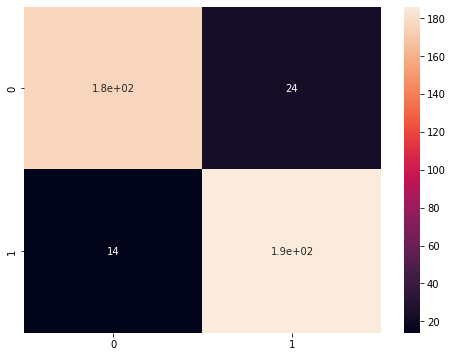

0.905


In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix


logreg = LogisticRegression(max_iter=1e5)
logreg.fit(XX_train, yy_train)
preds = logreg.predict(XX_test)
cf_matrix = confusion_matrix(yy_test, preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cf_matrix, annot=True)
plt.show()
print(logreg.score(XX_test, yy_test))

Получили результат за 90%, что уже само по себе неплохо. Попробуем другие подходы из классического машинного обучения, например RandomForest с разным количеством деревьев.

*Ещё раз приношу извинения за названия переменных, тут нужно откусить кусочек на валидацию*

In [20]:
XX_train_train = XX_train[:1500]
yy_train_train = yy_train[:1500]
XX_train_val = XX_train[1500:]
yy_train_val = yy_train[1500:]

100%|██████████| 50/50 [00:47<00:00,  1.06it/s]


best n_estimators = 37 with accuracy : 0.9820


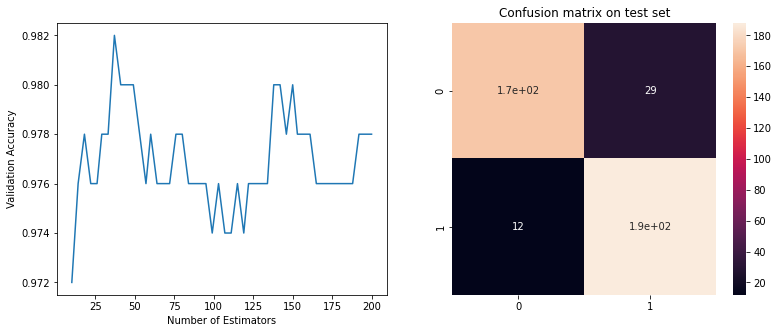

Random forest classifer accuracy on test set : 0.8975


In [43]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from tqdm import tqdm

estimators = []
estimators.append(('rf', RandomForestClassifier()))

forest_pl = Pipeline(estimators)
forest_pl.set_params(rf__random_state = seed)

scores = []
n_estimators = np.round(np.linspace(10, 200, 50))

for i in tqdm(range(len(n_estimators))):  
    forest_pl.set_params(rf__n_estimators = int(n_estimators[i]))
    forest_pl.fit(XX_train_train, yy_train_train)
    y_train_pred = forest_pl.predict(XX_train_val)
    scores.append(accuracy_score(yy_train_val, y_train_pred))

best_n_estimator = n_estimators[scores.index(max(scores))]
print ('best n_estimators = %d with accuracy : %2.4f' %(best_n_estimator, max(scores)))

forest_pl.set_params(rf__n_estimators = int(best_n_estimator))
forest_pl.fit(XX_train,yy_train)

y_pred = forest_pl.predict(XX_test)
score = accuracy_score(yy_test, y_pred)


plt.figure(figsize=(13, 5))

plt.subplot(1,2,1)
plt.plot( n_estimators,scores)
plt.xlabel('Number of Estimators')
plt.ylabel('Validation Accuracy')

plt.subplot(1,2,2)
cf_matrix = confusion_matrix(yy_test, y_pred)
sns.heatmap(cf_matrix, annot=True)
plt.title("Confusion matrix on test set")

plt.show()
print ('Random forest classifer accuracy on test set : %2.4f' %score)

Результаты не лучше, чем у регрессии. Попробуем градиентный бустинг.

100%|██████████| 20/20 [00:18<00:00,  1.06it/s]


best n_estimator = 40 with accuracy : 0.9800


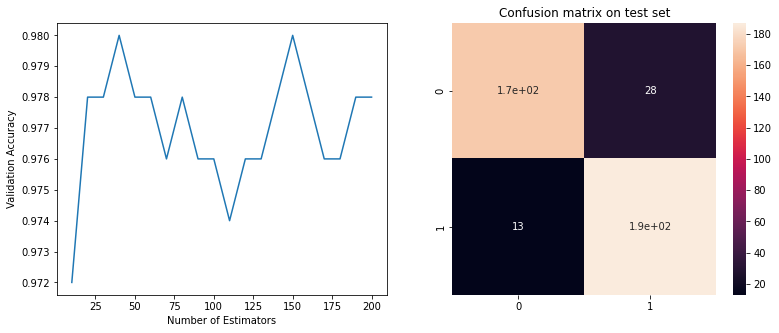

Gradient Boosting Trees classifier accuracy on test set: 0.8975


In [39]:
from sklearn.ensemble import GradientBoostingClassifier

estimators = []
estimators.append(('gb', GradientBoostingClassifier(random_state = seed)))

gradboost_pl = Pipeline(estimators)


scores = []
n_estimators = np.round(np.linspace(10, 200, 50))

for i in tqdm(range(len(n_estimators))):  
    gradboost_pl.set_params(rf__n_estimators = int(n_estimators[i]))
    gradboost_pl.fit(XX_train_train, yy_train_train)
    y_train_pred = gradboost_pl.predict(XX_train_val)
    scores.append(accuracy_score(yy_train_val, y_train_pred))

best_n_estimator = n_estimators[scores.index(max(scores))]
print ('best n_estimator = %d with accuracy : %2.4f' %(best_n_estimator, max(scores)))

gradboost_pl.set_params(gb__n_estimators = int(best_n_estimator))
gradboost_pl.fit(XX_train,yy_train)

y_pred = gradboost_pl.predict(XX_test)
score = accuracy_score(yy_test, y_pred)


plt.figure(figsize=(13, 5))

plt.subplot(1,2,1)
plt.plot( n_estimators,scores)
plt.xlabel('Number of Estimators')
plt.ylabel('Validation Accuracy')

plt.subplot(1,2,2)
cf_matrix = confusion_matrix(yy_test, y_pred)
sns.heatmap(cf_matrix, annot=True)
plt.title("Confusion matrix on test set")

plt.show()
print ('Gradient Boosting Trees classifier accuracy on test set: %2.4f' %score)

Ничего лучше не вышло. Время попробовать катбуст.

In [45]:
!pip install catboost


     |████████████████████████████████| 76.3 MB 64 kB/s 


0:	learn: 0.6557621	test: 0.6564443	best: 0.6564443 (0)	total: 22.1ms	remaining: 13.2s
10:	learn: 0.3912441	test: 0.4014154	best: 0.4014154 (10)	total: 209ms	remaining: 11.2s
20:	learn: 0.2694634	test: 0.2885549	best: 0.2885549 (20)	total: 382ms	remaining: 10.5s
30:	learn: 0.1953559	test: 0.2204927	best: 0.2204927 (30)	total: 550ms	remaining: 10.1s
40:	learn: 0.1499231	test: 0.1801991	best: 0.1801991 (40)	total: 733ms	remaining: 9.99s
50:	learn: 0.1208393	test: 0.1529703	best: 0.1529703 (50)	total: 913ms	remaining: 9.83s
60:	learn: 0.1015688	test: 0.1345854	best: 0.1345854 (60)	total: 1.09s	remaining: 9.65s
70:	learn: 0.0869564	test: 0.1216742	best: 0.1216742 (70)	total: 1.28s	remaining: 9.56s
80:	learn: 0.0736703	test: 0.1095955	best: 0.1095955 (80)	total: 1.47s	remaining: 9.45s
90:	learn: 0.0636770	test: 0.1005029	best: 0.1005029 (90)	total: 1.67s	remaining: 9.33s
100:	learn: 0.0562157	test: 0.0941849	best: 0.0941849 (100)	total: 1.85s	remaining: 9.14s
110:	learn: 0.0498946	test: 0.0

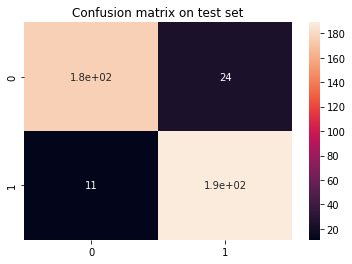

Gradient Boosting Trees classifier accuracy on test set: 0.9125


In [127]:
from catboost import CatBoostClassifier

model = CatBoostClassifier(
  iterations=600,
  learning_rate=0.03
)

model.fit(
    XX_train_train, yy_train_train,
    eval_set=(XX_train_val, yy_train_val),
    verbose=10
)

y_pred = model.predict(XX_test)
score = accuracy_score(yy_test, y_pred)

cf_matrix = confusion_matrix(yy_test, y_pred)
sns.heatmap(cf_matrix, annot=True)
plt.title("Confusion matrix on test set")

plt.show()
print ('Gradient Boosting Trees classifier accuracy on test set: %2.4f' %score)

In [130]:
model.save_model('cb_model.cbm')

Получается немного получше, наверное если увеличить датасет, можно прийти к более точной модели. Делать я этого не буду из-за слабости интернета.

Переходим к настоящему машинному обучению!
Посмотрим, что сможет несложная нейросеть с парой всёрточных слоёв.

In [73]:
import torch.utils as utils

train_data = []
for i in range(2000):
  train_data.append([X_train[i], ([0] if y_train[i] == 'female' else [1])])
test_data = []
for i in range(400):
  test_data.append([X_test[i], ([0] if y_test[i] == 'female' else [1])])

In [74]:
train_loader = utils.data.DataLoader(train_data, 
                                           batch_size=20,
                                           shuffle=True,
                                           num_workers=2)
test_loader = utils.data.DataLoader(test_data,
                                          batch_size=200,
                                          shuffle=True,
                                          num_workers=2)

In [118]:
import torch.nn as nn

class Net(nn.Module):   
    def __init__(self):
        super(Net, self).__init__()

        self.cnn_layers = nn.Sequential(
            nn.Conv1d(64, 128, kernel_size=3, stride=1),
            nn.BatchNorm1d(128),
            nn.Dropout(0.2),
            nn.ReLU(inplace=True),
            nn.AvgPool1d(kernel_size=2, stride=4),
            nn.Conv1d(128, 256, kernel_size=3, stride=1),
            nn.BatchNorm1d(256),
            nn.Dropout(0.2),
            nn.ReLU(inplace=True),
            nn.AvgPool1d(kernel_size=2, stride=8),
        )

        self.linear_layers = nn.Sequential(
            nn.Linear(4096, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Linear(64, 1),
        )

    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x


In [122]:

import torch.optim as optim
import torchsummary

model = Net()

optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.BCEWithLogitsLoss()

print(torchsummary.summary(model, (64, 512)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1             [-1, 128, 510]          24,704
       BatchNorm1d-2             [-1, 128, 510]             256
           Dropout-3             [-1, 128, 510]               0
              ReLU-4             [-1, 128, 510]               0
         AvgPool1d-5             [-1, 128, 128]               0
            Conv1d-6             [-1, 256, 126]          98,560
       BatchNorm1d-7             [-1, 256, 126]             512
           Dropout-8             [-1, 256, 126]               0
              ReLU-9             [-1, 256, 126]               0
        AvgPool1d-10              [-1, 256, 16]               0
           Linear-11                   [-1, 64]         262,208
             ReLU-12                   [-1, 64]               0
      BatchNorm1d-13                   [-1, 64]             128
           Linear-14                   

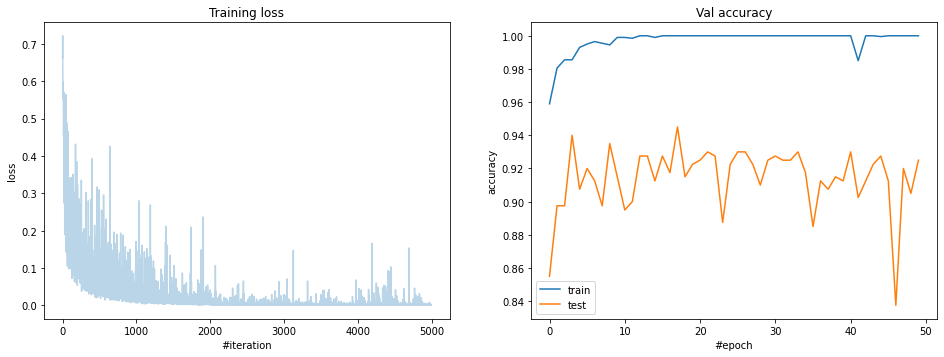

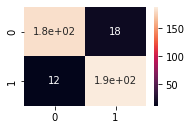

Accuracy score: 0.925000


In [123]:
from sklearn.metrics import accuracy_score
from IPython.display import clear_output
import torch
from sklearn.metrics import confusion_matrix


n_epochs = 50

losses = []
losses_val = []
accuracy_scores = []
accuracy_scores_val = []
for i in range(n_epochs):
  model.train()
  tr_loss = 0
  
  for x_batch, y_batch in train_loader:
    optimizer.zero_grad()
    predictions = model.forward(x_batch)
    loss = criterion(predictions.squeeze().float(), torch.stack(y_batch).squeeze().float())
    losses.append(loss.item())
    loss.backward()

    optimizer.step()

  clear_output(wait=True)
  plt.figure(figsize=(16, 12))

  model.eval()

  accuracy = []
  accuracy_val = []
  cf_matrix = np.zeros((2, 2))
  for x_batch, y_batch in test_loader:
    y_pred = torch.round(torch.sigmoid(model.forward(x_batch))).data.numpy()
    y = y_batch[0]
    accuracy_val.append(accuracy_score(y, y_pred))
    cf_matrix += confusion_matrix(y, y_pred)
  for x_batch, y_batch in train_loader:
    y_pred =  torch.round(torch.sigmoid(model.forward(x_batch))).data.numpy()
    accuracy.append(accuracy_score(y_pred, y_batch[0]))
  accuracy_scores.append(sum(accuracy) / len(accuracy))
  accuracy_scores_val.append(sum(accuracy_val) / len(accuracy_val))

  plt.subplot(2, 2, 1)    
  plt.title("Training loss")
  plt.xlabel("#iteration")
  plt.ylabel("loss")
  plt.plot(losses, alpha=0.3,)

  plt.subplot(2, 2, 2)
  plt.title("Val accuracy")
  plt.xlabel("#epoch")
  plt.ylabel("accuracy")
  plt.plot(accuracy_scores, label='train')
  plt.plot(accuracy_scores_val, label='test')
  plt.legend()
  plt.show()

  plt.subplot(2, 2, 3)
  sns.heatmap(cf_matrix, annot=True)
  plt.show()


  print('Accuracy score: %f' % accuracy_scores_val[-1])


In [126]:
torch.save(model.state_dict(), 'net_model.pth')

Попробовала несколько разных конфигураций, эта одна из лучших, достигает почти 93%. Довольно заметно переобучение модели, думаю причина, в том, что датасет относительно небольшой, поэтому сеть запоминает конкретные голоса. К сожалению, у меня недостаточно ресурсов, чтобы использовать весь датасет.

**Небольшой вывод о проделанной работе**

Для имеющихся данных рассмотрела классические модели, на которых была достигнута точность чуть больше 91% и построила свёрточную нейросеть, которая показала точность 92.5%. В перспективе с увеличением датасета должны улучшать свои результаты варианты с использованием катбуста и свёрточной нейросети.